## Chapter 1:

In [1]:
# libs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import pymc3 as pm
import arviz as az

In [2]:
# diy MCMC algorithm using metroplis hasting algorithm

def post(theta, Y, alpha=1, beta=1):
    if 0 <= theta <= 1:
        prior = stats.beta(alpha, beta).pdf(theta) # pdf of a given point
        likelihood = stats.bernoulli(theta).pmf(Y).prod() 
        prob = prior * likelihood
    else:
        prob = -np.inf
    return prob

# try it out
# plot the beta distribution
x = np.linspace(0, 1, 100)
#plt.plot(x, stats.beta.pdf(x, 2, 2))

# plot a given point based on theta
theta = 0.5
#plt.plot(theta, stats.beta.pdf(theta, 2, 2), 'ro')

# create some fake data
Y = stats.bernoulli(0.75).rvs(100)

# run our algorithm
n_iter = 10
can_sd = 0.05
alpha=beta=1
trace = {'theta': np.zeros(n_iter)}

p2 = post(theta, Y, alpha, beta)

for iter in range(n_iter):
    
    # propose a new value from a prior distribution
    # based on the normal distro
    theta_prop = stats.norm(theta, can_sd).rvs(1)
    
    # calculate the probability of the proposed value
    p1 = post(theta_prop, Y, alpha, beta)
    
    # calculate the probability of the current value
    pa = p1 /p2

    if pa > stats.uniform(0, 1).rvs(1):
        theta = theta_prop
        p2 = p1
    # store the value
    trace['theta'][iter] = theta

    # recreate the awesome plot from 
    # https://blog.stata.com/2016/11/15/introduction-to-bayesian-statistics-part-2-mcmc-and-the-metropolis-hastings-algorithm/

    # plot the trace


,mean,sd,hdi_3%,hdi_97%
theta,0.55,0.03,0.5,0.58


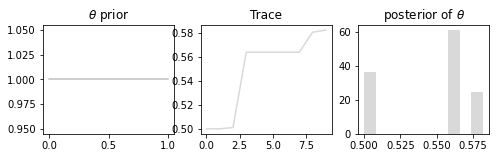

In [3]:

# create a plot of the trace and posterior
_, axes = plt.subplots(1, 3, sharey=False, figsize=(8, 2))

# plot the prior
axes[0].plot(x, stats.beta.pdf(x, alpha, beta), color='0.75')
axes[1].plot(trace['theta'], color='0.85')
axes[2].hist(trace['theta'], color='0.85', density=True)

axes[0].set_title('$\\theta$ prior')
axes[1].set_title('Trace')
axes[2].set_title('posterior of $\\theta$')

# summarize the trace
az.summary(trace, kind='stats', round_to=2)

In [4]:
# let's try the same thing again... but with pymc3
with pm.Model() as binom_model:
    # define the prior
    theta = pm.Beta('theta', alpha=alpha, beta=beta)
    
    # define the likelihood
    Y = pm.Binomial('Y', n=1, p=theta, observed=Y)
    
    # run the sampler
    trace = pm.sample(n_iter, tune=1000, return_inferencedata=False)


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 12 seconds.
/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/benjaminharder/miniconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

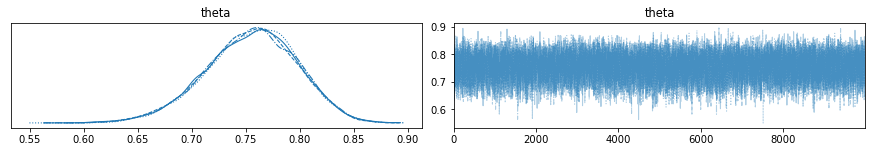

In [44]:
# check out the summary and trace information using arviz
az.summary(trace, kind='stats', round_to=2);
az.plot_trace(trace)

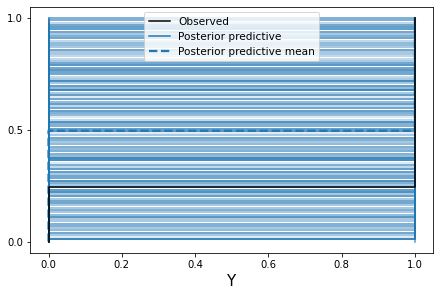

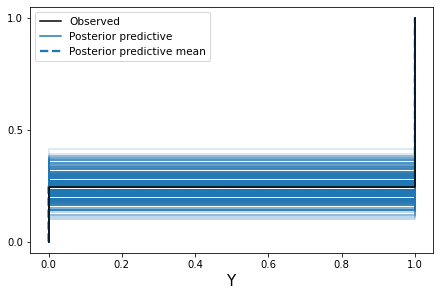

In [54]:
# sample from prior
with binom_model:
    prior_pc = pm.sample_prior_predictive()
    ppc = pm.fast_sample_posterior_predictive(trace=trace, random_seed=1)
    # generate inference data
    idata = az.from_pymc3(trace=trace,
                          prior=prior_pc,
                          posterior_predictive=ppc,
                             )
az.plot_ppc(data=idata, num_pp_samples=500, group='prior', kind='cumulative');
az.plot_ppc(data=idata, num_pp_samples=500, group='posterior', kind='cumulative');


(array([[4.98, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.02],
        [5.21, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.79],
        [4.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.01],
        [5.14, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.86],
        [5.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.94],
        [5.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.92],
        [5.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.85],
        [5.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.99],
        [5.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.94],
        [5.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.98],
        [4.92, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 5.08],
        [5.26, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.74],
        [5.31, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.69],
        [5.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 4.96],
        [5.17, 0.  ,

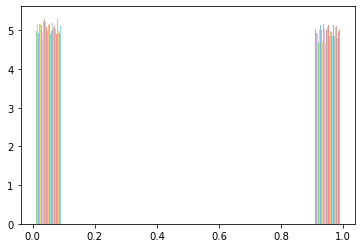

In [32]:
# create prior and posterior predictive plots
pred_dists = (pm.sample_prior_predictive(1000, binom_model)['Y'], 
              pm.sample_posterior_predictive(trace, 1000, binom_model)['Y'])

# plot the prior and posterior predictive
plt.hist(pred_dists[0], density=True, alpha=0.5, label='prior')
#plt.hist(pred_dists[1], density=True, alpha=0.5, label='posterior predictive')

In [21]:
pred_dists[1]

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])